Pre-working stuff

In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pip install toai-mokahaiku

     |████████████████████████████████| 153kB 5.0MB/s 
     |████████████████████████████████| 81kB 26.7MB/s 
     |████████████████████████████████| 296kB 53.9MB/s 
     |████████████████████████████████| 61kB 23.0MB/s 
  Created wheel for fastparquet: filename=fastparquet-0.3.2-cp36-cp36m-linux_x86_64.whl size=253214 sha256=51466ac407ad675eb92814e7f786d083d1db4328e9593223427dbfdc3787f18b
  Stored in directory: /root/.cache/pip/wheels/b9/36/13/01416a760ddcab0eb8281ec9c9ffcbed945c9b831647c8b904
  Created wheel for thrift: filename=thrift-0.11.0-cp36-cp36m-linux_x86_64.whl size=326454 sha256=49aa2b6f9a8f992b3824aa1f7a7fc55bf49ad47cb29b0673098b61d98bf61d4a
  Stored in directory: /root/.cache/pip/wheels/be/36/81/0f93ba89a1cb7887c91937948519840a72c0ffdd57cac0ae8f
Successfully built fastparquet thrift


In [2]:
from toai.imports import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
import tensorflow as tf

In [6]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 98kB/s 
     |████████████████████████████████| 3.1MB 42.7MB/s 
     |████████████████████████████████| 501kB 54.0MB/s 


In [95]:
tf.__version__

'2.0.0-beta1'

In [0]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISABLE_DEVICES']='0'

In [0]:
DATA_DIR = Path('data/Bees')
TEMP_DIR = Path('temp/Bees')

In [0]:
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d jenny18/honey-bee-annotated-images --unzip -p {DATA_DIR}

100% 50.0M/50.1M [00:00<00:00, 59.3MB/s]
100% 50.1M/50.1M [00:00<00:00, 93.0MB/s]


In [0]:
shutil.unpack_archive(str(DATA_DIR/'bee_imgs.zip'), extract_dir=str(DATA_DIR/'bee_imgs.zip'[:-4]))

In [0]:
data = pd.read_csv(DATA_DIR/'bee_data.csv')




Exploratory analysis



File name in bee_imgs folder
date

Date of video captures
time

Time of day of video capture (military time)
location

Location (city, state, country)
zip code

Zip Code to numerically describe location
subspecies

Subspecies of Apis mellifera species
health

Health of a bee
pollen_carrying

Presence of pollen on the bee's legs
caste

Worker, Drone, or Queen bee

In [43]:
data.head(5).T



,0,1,2,3,4
file,041_066.png,041_072.png,041_073.png,041_067.png,041_059.png
date,8/28/18,8/28/18,8/28/18,8/28/18,8/28/18
time,16:07,16:07,16:07,16:07,16:07
location,"Alvin, TX, USA","Alvin, TX, USA","Alvin, TX, USA","Alvin, TX, USA","Alvin, TX, USA"
zip code,77511,77511,77511,77511,77511
subspecies,-1,-1,-1,-1,-1
health,hive being robbed,hive being robbed,hive being robbed,hive being robbed,hive being robbed
pollen_carrying,False,False,False,False,False
caste,worker,worker,worker,worker,worker


In [0]:
train_df, test_df = train_test_split(data, test_size=0.2)



In [0]:
test_df, val_df = train_test_split(test_df, test_size=0.5)


In [0]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [103]:
[x.shape for x in (train_df, test_df, val_df)]

[(4137, 9), (517, 9), (518, 9)]

Model preparation

In [0]:
target_col = "health"
image_path_col = "file"
IMG_DIMS = (99, 99)

In [0]:
label_pipeline = LabelEncoder()

In [106]:
label_pipeline.fit_transform(train_df[target_col])

array([2, 3, 2, ..., 3, 3, 3])

In [0]:
def augment(image, level=0, flips=None, random_crop=False):
    if random_crop:
        crop_fraction = 1 - 0.05 * level
        scaled_dim = tf.to_int32(
            crop_fraction * tf.to_float(tf.reduce_min(tf.shape(image)[:2]))
        )
        image = tf.image.random_crop(image, (scaled_dim, scaled_dim, 3))
        image = tf.image.resize(image, IMG_DIMS)

    if flips in ["horizontal", "both"]:
        image = tf.image.random_flip_left_right(image)
    if flips in ["vertical", "both"]:
        image = tf.image.random_flip_up_down(image)

    if level > 0:
        lower = 1 - 0.1 * level
        upper = 1 + 0.1 * level
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image

In [0]:
def image_parse(filename, preprocess_fn, img_dims, mode):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = preprocess_fn(image)
    if mode == "stretch":
        image = tf.image.resize(image, img_dims)
    elif mode == "crop":
        image = tf.image.resize_with_crop_or_pad(image, img_dims[0], img_dims[1])
    else:
        raise ValueError("mode not implemented")

    return image

In [0]:
def prepare_ds(
    x,
    y,
    batch_size,
    parse_fn,
    augment_fn,
    mode,
    shuffle=False,
    num_parallel_calls=1,
):
    dataset_length = len(x)
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(
        parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS, mode=mode
    )

    image_ds = (
        tf.data.Dataset.from_tensor_slices(x)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    )
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y, tf.float32))
    ds = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        ds = ds.shuffle(dataset_length)

    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(1)
    return ds, dataset_length, batch_size

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"bee_imgs/bee_imgs"/f"{getattr(row, image_path_col)}") for row in train_df.itertuples()]),
    y=label_pipeline.transform(train_df[target_col]),
    batch_size=16,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=2),
    mode="crop",
    shuffle=True,
    num_parallel_calls=2,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"bee_imgs/bee_imgs"/f"{getattr(row, image_path_col)}") for row in val_df.itertuples()]),
    y=label_pipeline.transform(val_df[target_col]),
    batch_size=16,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="stretch",
    shuffle=False,
    num_parallel_calls=2,
)

In [0]:
test_dataset, test_dataset_length, test_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"bee_imgs/bee_imgs"/f"{getattr(row, image_path_col)}") for row in test_df.itertuples()]),
    y=label_pipeline.transform(test_df[target_col]),
    batch_size=16,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="stretch",
    shuffle=False,
    num_parallel_calls=2,
)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow(x[0])
        ax[i // cols, i % cols].set_title(y[0].numpy())

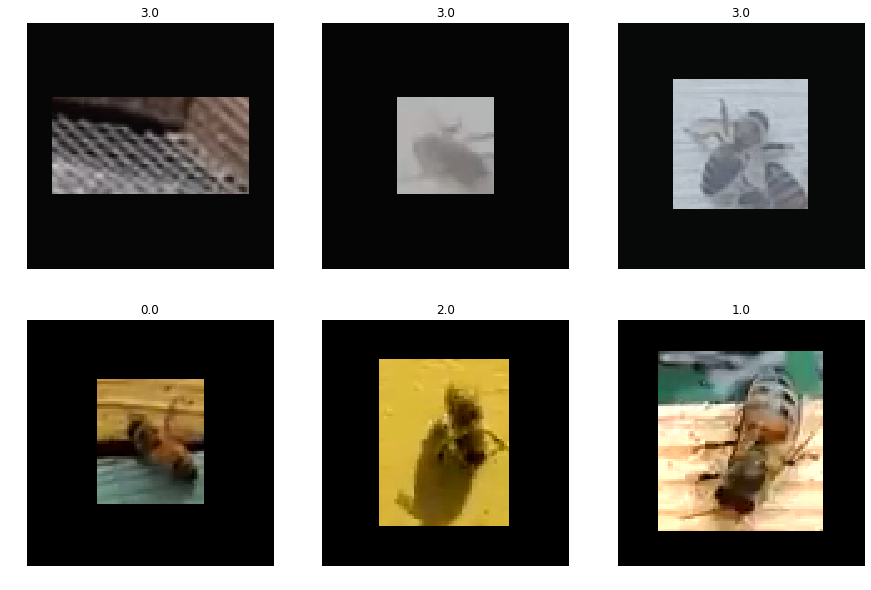

In [114]:
plot_dataset(train_dataset, 2, 3)

In [0]:
def make_model(
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.Xception(include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
from tensorflow import keras


In [0]:
dimensions = [
    skopt.space.Categorical([
        keras.optimizers.Adam,
        keras.optimizers.Nadam,
        keras.optimizers.RMSprop,
    ], name='optimizer'),
    skopt.space.Real(low=1e-6, high=1e-3, prior='log-uniform', name='lr'),
    skopt.space.Real(low=0., high=0.5, name='dropout'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l1_reg'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l2_reg'),
    skopt.space.Integer(low=6, high=30, name='epochs'),
    skopt.space.Integer(low=0, high=10, name='easing_epochs'),
]

In [0]:
default_parameters = [keras.optimizers.Nadam, 1e-6, 0.2, 1e-8, 1e-8, 10, 3]

In [0]:
best_accuracy = 0.0
best_model_arch_path = str(TEMP_DIR/'best_model.json')
best_model_weights_path = str(TEMP_DIR/'best_model.h5')

In [0]:
def train_model(model, optimizer, lr, epochs, easing_epochs):
    if easing_epochs:
        for layer in model.layers[:-1]:
            layer.trainable = False

        model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
            ],
        )
        
        easing_reduce_lr_patience = min(1, easing_epochs // 3)
        easing_early_stopping_patience = min(1, easing_epochs // 2)

        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True),  
            ],
            verbose=0,
        )
        
        for layer in model.layers:
            layer.trainable = True
        
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
    
    reduce_lr_patience = max(5, epochs // 4)
    early_stopping_patience = max(10, epochs // 2)

    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),  
        ],
        verbose=1,
    )
    
    return history

In [0]:
input_shape = IMG_DIMS + (3,)

@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(
    optimizer,
    lr,
    dropout,
    l1_reg,
    l2_reg,
    epochs,
    easing_epochs,
):  
    model = make_model(
        n_classes,
        input_shape,
        dropout,
        l1_reg,
        l2_reg,
    )
    
    history = train_model(model, optimizer, lr, epochs, easing_epochs)

    accuracy = max(history.history["val_sparse_categorical_accuracy"])

    print("\nAccuracy: {0:.2%}\n".format(accuracy))

    global best_accuracy

    if accuracy > best_accuracy:
        print('Best model'.center(80, '-'))
        print("Accuracy: {0:.4%}".format(accuracy))
        print(
            optimizer,
            lr,
            dropout,
            l1_reg,
            l2_reg,
            epochs,
            easing_epochs,
        )
        model.save_weights(best_model_weights_path)
        with open(best_model_arch_path, "w") as f:
            f.write(model.to_json())
        best_accuracy = accuracy

    del model

    keras.backend.clear_session()

    return -accuracy

In [125]:
search_result = skopt.gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=15,
    x0=default_parameters,
)

KeyboardInterrupt: ignored

In [0]:


def load_model(arch, weights):
    with open(arch, "r") as f:
        model = keras.models.model_from_json(f.read())
    model.load_weights(weights)
    return model



In [0]:
model = load_model(best_model_arch_path, best_model_weights_path)

In [0]:


model.compile(
    optimizer=keras.optimizers.SGD(1),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
    ],
)



In [129]:
model.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))

33/33 [==============================] - 3s 85ms/step - loss: 0.7340 - sparse_categorical_accuracy: 0.7664


[0.7339698559407032, 0.7664093]

In [0]:


val_predictions = model.predict(
    val_dataset,
    steps=math.ceil(val_dataset_length/val_batch_size),
)



In [0]:
val_labels = np.concatenate([
    y.numpy() for _, y in val_dataset.take(math.ceil(val_dataset_length/val_batch_size))
])

In [132]:
print(classification_report(val_labels, val_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       1.00      0.02      0.05        43
         1.0       0.85      0.70      0.77        47
         2.0       0.54      0.35      0.43        57
         3.0       0.86      0.93      0.89       344
         4.0       0.34      0.92      0.50        25
         5.0       0.00      0.00      0.00         2

    accuracy                           0.77       518
   macro avg       0.60      0.49      0.44       518
weighted avg       0.81      0.77      0.74       518



In [0]:


test_predictions = model.predict(
    test_dataset,
    steps=math.ceil(test_dataset_length/test_batch_size),
)



In [0]:
test_labels = np.concatenate([
    y.numpy() for _, y in test_dataset.take(math.ceil(test_dataset_length/test_batch_size))
])

In [135]:
print(classification_report(test_labels, test_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       1.00      0.04      0.07        52
         1.0       0.94      0.72      0.81        46
         2.0       0.50      0.39      0.44        51
         3.0       0.85      0.93      0.89       348
         4.0       0.27      0.94      0.42        16
         5.0       0.25      0.25      0.25         4

    accuracy                           0.76       517
   macro avg       0.64      0.54      0.48       517
weighted avg       0.82      0.76      0.74       517



In [0]:
IMG_DIMS = 